In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')

In [4]:
env.vars.load_json('strengths_quads_00_arc_cell.json')
env.vars.load_json('strengths_quads_01_ffccsyl.json')
env.vars.load_json('strengths_quads_02_ffccsxl.json')
env.vars.load_json('strengths_quads_03_ffccsyr.json')
env.vars.load_json('strengths_quads_04_ffccsxr.json')
env.vars.load_json('strengths_quads_05_ffds_lr.json')
env.vars.load_json('strengths_quads_06_straight.json')

env.vars.load_json('strengths_sext_00_arc_cell.json')

In [5]:
# Select machine portion
line = env['fccee_p_ring']
section = line.select('mid_cell_edge_r::1','mid_cell_edge_l::2')

In [6]:
# Twiss arc mid cells to get boundary conditions
cell1 = line.select('mid_cell_edge_l::1','mid_cell_edge_r::1')
cell2 = line.select('mid_cell_edge_l::2','mid_cell_edge_r::2')

tw_cell_1 = cell1.twiss4d()
twinit_cell_1_r = tw_cell_1.get_twiss_init('mid_cell_edge_r')
tw_cell_2 = cell2.twiss4d()
twinit_cell_2_l = tw_cell_1.get_twiss_init('mid_cell_edge_l')

In [7]:
tw_no_ip_sext = section.twiss(init=twinit_cell_1_r,
                    compute_chromatic_properties=True)

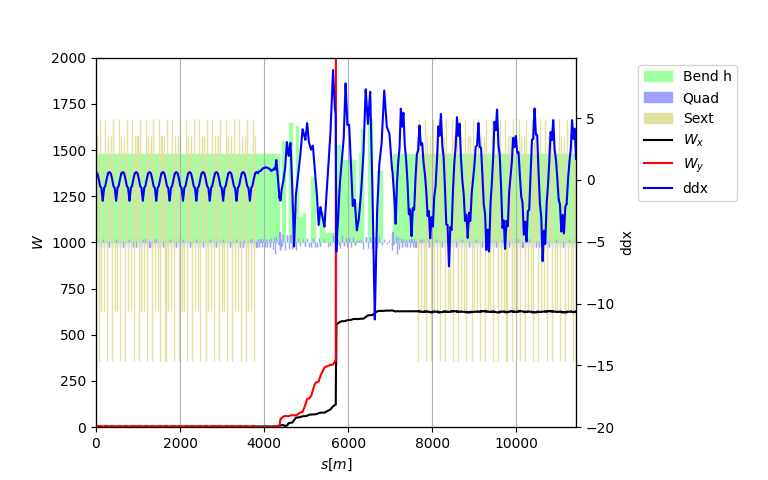

In [8]:
# W functions and second order dispersion before match
pp = tw_no_ip_sext.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=2000, right_lo=-20)

### Start by using chromatic correction sextupoles to minimize W at IP (from the left and from the right)

In [9]:
opt_w_left = section.match(
    name='w_left',
    solve=False,
    init=twinit_cell_1_r,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksfx1l', 'ksdy1l'], step=1e-3),
    targets=xt.TargetSet(wx_chrom=0, wy_chrom=0, at='ip_mid')
)
opt = opt_w_left
opt.step(10)

# Match from right to left
opt_w_right = section.match(
    name='w_right',
    solve=False,
    init=twinit_cell_2_l,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksfx1r', 'ksdy1r'], step=1e-3),
    targets=xt.TargetSet(wx_chrom=0, wy_chrom=0, at='ip_mid')
)
opt = opt_w_right
opt.step(10)

                                             
Optimize [w_left] - start penalty: 4795                         
Matching: model call n. 67 penalty = 1.1350e+01              
Optimize [w_left] - end penalty:  11.3496                            
                                             
Optimize [w_right] - start penalty: 4922                         
Matching: model call n. 66 penalty = 7.8231e+00              
Optimize [w_right] - end penalty:  7.82308                            


In [10]:
# Match W functions to those of the arcs
opt_close_w = section.match(
    name='close',
    solve=False,
    init=twinit_cell_1_r,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksfx1l', 'ksdy1l', 'ksfx1r', 'ksdy1r'], step=1e-3),
    targets=[xt.TargetSet(ax_chrom=twinit_cell_1_r.ax_chrom,
                         ay_chrom=twinit_cell_1_r.ay_chrom,
                         bx_chrom=twinit_cell_1_r.bx_chrom,
                         by_chrom=twinit_cell_1_r.by_chrom,
                         at=xt.END),
            xt.TargetSet(wx_chrom=xt.LessThan(10), wy_chrom=xt.LessThan(10),
                         at='ip_mid')]
)
opt = opt_close_w
opt.step(10)

                                             
Optimize [close] - start penalty: 5.275                         
Matching: model call n. 81 penalty = 3.9462e+00              
Optimize [close] - end penalty:  3.94622                            


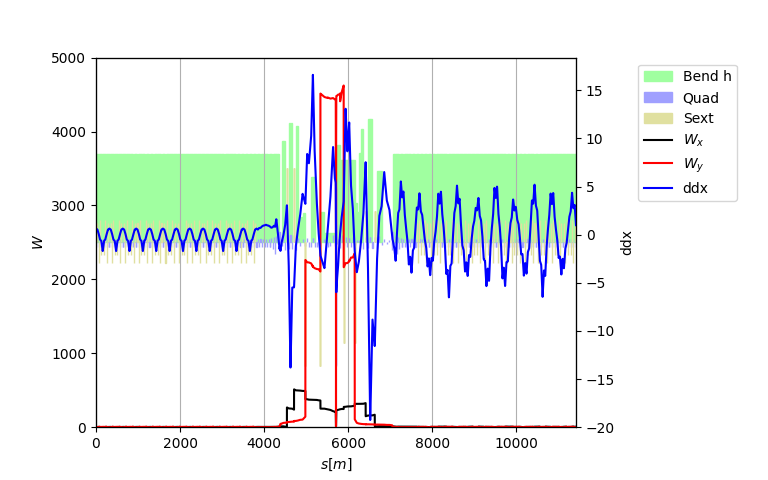

In [11]:
# W functions and second order dispersion before match
pp = opt.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=5000, right_lo=-20)

In [12]:
import sys
sys.path.append('../002_design_optics/')
from local_nl_chromaticity import LocalNonLinearChromaticity

### Non linear chromatic behaviour

In [13]:
act = LocalNonLinearChromaticity(section=section)

In [14]:
nlchr_0 = act.run()

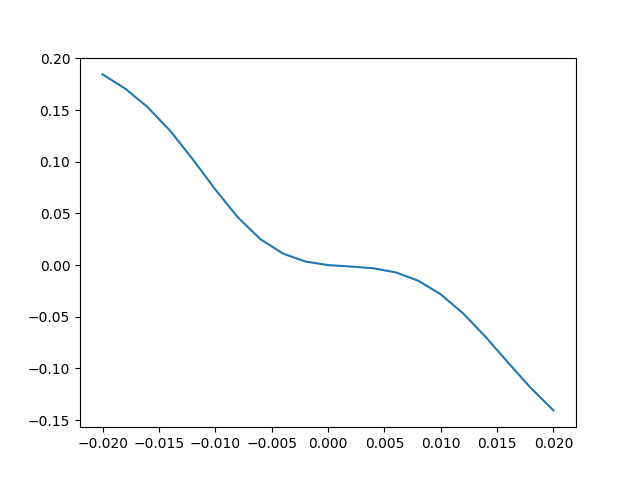

In [15]:
plt.figure()
plt.plot(nlchr_0['delta_test'], nlchr_0['mux_r_test'])

In [16]:
# Match third order chromaticity
opt_chrom3_y_left = section.match(
    name='chrom3_l_y',
    solve=False,
    vary=xt.VaryList(['ksdm1l'], step=1e-3, limits=[-0.5, 0.5]),
    targets=[
        act.target('dmuy_l', xt.LessThan(0.1), tol=0.01, weight=1e4, tag='dmuy_l'),
        act.target('dmuy_l', xt.GreaterThan(-0.1), tol=0.01, weight=1e4, tag='dmux_l'),
        act.target('d3muy_l', xt.LessThan(1e3), tol=1, weight=1, tag='d3muy_l'),
        act.target('d3muy_l', xt.GreaterThan(-1e3), tol=1, weight=1, tag='d3muy_l'),
        act.target('muy_rms_l', xt.LessThan(0.05), tol=0.1, weight=1e6, tag='muy_rms_l'),
    ]
)
opt = opt_chrom3_y_left
opt.run_direct(20)

opt_chrom3_x_left = section.match(
    name='chrom3_l_x',
    solve=False,
    vary=xt.VaryList(['ksfm2l'], step=1e-3, limits=[-0.5, 0.5]),
    targets=[
        act.target('dmux_l', xt.LessThan(0.1), tol=0.01, weight=1e4, tag='dmux_l'),
        act.target('dmux_l', xt.GreaterThan(-0.1), tol=0.01, weight=1e4, tag='dmux_l'),
        act.target('d3mux_l', xt.LessThan(1e3), tol=1, weight=1, tag='d3mux_l'),
        act.target('d3mux_l', xt.GreaterThan(-1e3), tol=1, weight=1, tag='d3mux_l'),
        act.target('mux_rms_l', xt.LessThan(0.05), tol=0.1, weight=1e6, tag='mux_rms_l'),
    ]
)
opt = opt_chrom3_x_left
opt.run_direct(20)

opt_chrom3_y_right = section.match(
    name='chrom3_r_y',
    solve=False,
    vary=xt.VaryList(['ksdm1r'], step=1e-3, limits=[-0.5, 0.5]),
    targets=[
        act.target('dmuy_r', xt.LessThan(1), tol=0.01, weight=1e4, tag='dmuy_r'),
        act.target('dmuy_r', xt.GreaterThan(-1), tol=0.01, weight=1e4, tag='dmuy_r'),
        act.target('d3muy_r', xt.LessThan(3e3), tol=1, weight=1, tag='d3muy_r'),     # For some reason this givea a better behaviour in the closed twiss
        act.target('d3muy_r', xt.GreaterThan(-3e3), tol=1, weight=1, tag='d3muy_r'), # Allowing to go to delta 1.5e-2
        act.target('muy_rms_r', xt.LessThan(0.05), tol=0.1, weight=1e6, tag='muy_rms_r'),
    ]
)
opt = opt_chrom3_y_right
opt.run_direct(20)

opt_chrom3_x_right = section.match(
    name='chrom3_r_x',
    solve=False,
    vary=xt.VaryList(['ksfm2r'], step=1e-3, limits=[-0.5, 0.5]),
    targets=[
        act.target('dmux_r', xt.LessThan(0.1), tol=0.01, weight=1e4, tag='dmux_r'),
        act.target('dmux_r', xt.GreaterThan(-0.1), tol=0.01, weight=1e4, tag='dmux_r'),
        act.target('d3mux_r', xt.LessThan(1e3), tol=1, weight=1, tag='d3mux_r'),
        act.target('d3mux_r', xt.GreaterThan(-1e3), tol=1, weight=1, tag='d3mux_r'),
        act.target('mux_rms_r', xt.LessThan(0.05), tol=0.1, weight=1e6, tag='mux_rms_r'),
    ]
)
opt = opt_chrom3_x_right
opt.run_direct(20)


                                             
Optimize [chrom3_l_y] - start penalty: 2.115e+05                         
Matching: model call n. 24 penalty = 8.4554e+03              
Optimize [chrom3_l_y] - end penalty:  8455.35                            
                                             
Optimize [chrom3_l_x] - start penalty: 3.431e+05                         
Matching: model call n. 24 penalty = 3.4435e+04              
Optimize [chrom3_l_x] - end penalty:  34435.2                            
                                             
Optimize [chrom3_r_y] - start penalty: 1.93e+05                         
Matching: model call n. 24 penalty = 7.8097e+03              
Optimize [chrom3_r_y] - end penalty:  7809.74                            
                                             
Optimize [chrom3_r_x] - start penalty: 3.093e+05                         
Matching: model call n. 24 penalty = 7.4576e+03              
Optimize [chrom3_r_x] - end penalty:  7457.64      

In [17]:
# # Define circuits in special cells
vars_ds_sextupoles = {}
vars_ds_sextupoles['ksf2al3'] = 'ksffam2 + ksf2al3_delta'
vars_ds_sextupoles['ksd1al3'] = 'ksdfam1'
vars_ds_sextupoles['ksf1al3'] = 'ksffam1 + ksf1al3_delta'
vars_ds_sextupoles['ksd2al3'] = 'ksdfam2'
vars_ds_sextupoles['ksd2bl3'] = 'ksdfam2'
vars_ds_sextupoles['ksf1bl3'] = 'ksffam1 + ksf1bl3_delta'
vars_ds_sextupoles['ksd1bl3'] = 'ksdfam1'
vars_ds_sextupoles['ksf2bl3'] = 'ksffam2 + ksf2bl3_delta'
vars_ds_sextupoles['ksf2fl']  = 'ksffam2 + ksf2fl_delta'
vars_ds_sextupoles['ksd1fl']  = 'ksdfam1'
vars_ds_sextupoles['ksf1fl']  = 'ksffam1 + ksf1fl_delta'
vars_ds_sextupoles['ksd2fl']  = 0
vars_ds_sextupoles['ksf3fl']  = 0
vars_ds_sextupoles['ksf3fr']  = 0
vars_ds_sextupoles['ksd2fr']  = 0
vars_ds_sextupoles['ksf1fr']  = 'ksffam1 + ksf1fr_delta'
vars_ds_sextupoles['ksd1fr']  = 'ksdfam1'
vars_ds_sextupoles['ksf2fr']  = 'ksffam2 + ksf2fr_delta'
vars_ds_sextupoles['ksf2br3'] = 'ksffam2 + ksf2br3_delta'
vars_ds_sextupoles['ksd1br3'] = 'ksdfam1'
vars_ds_sextupoles['ksf1br3'] = 'ksffam1 + ksf1br3_delta'
vars_ds_sextupoles['ksd2br3'] = 'ksdfam2'
vars_ds_sextupoles['ksd2ar3'] = 'ksdfam2'
vars_ds_sextupoles['ksf1ar3'] = 'ksffam1 + ksf1ar3_delta'
vars_ds_sextupoles['ksd1ar3'] = 'ksdfam1'
vars_ds_sextupoles['ksf2ar3'] = 'ksffam2 + ksf2ar3_delta'
env.vars.default_to_zero = True
env.vars.update(vars_ds_sextupoles)
env.vars.default_to_zero = True

ddx_left_knobs = ['ksf2al3_delta', 'ksf1al3_delta', 'ksf1bl3_delta',
                  'ksf2bl3_delta', 'ksf2fl_delta', 'ksf1fl_delta']
ddx_right_knobs = ['ksf1fr_delta', 'ksf2fr_delta', 'ksf2br3_delta',
                   'ksf1br3_delta', 'ksf1ar3_delta', 'ksf2ar3_delta']


In [18]:
opt_ddx_left = section.match(
    name='ddx_left',
    solve=False,
    init=twinit_cell_1_r,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksf2al3_delta', 'ksf1al3_delta', 'ksf1bl3_delta',
                      'ksf2bl3_delta', 'ksf2fl_delta', 'ksf1fl_delta'], step=1e-4),
    targets=xt.TargetSet(ddx=0, ddpx=-0, at='ip_mid')
)
opt = opt_ddx_left
opt.step(5)


opt_ddx_right = section.match(
    name='ddx_right',
    solve=False,
    init=twinit_cell_2_l,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksf1fr_delta', 'ksf2fr_delta', 'ksf2br3_delta',
                     'ksf1br3_delta', 'ksf1ar3_delta', 'ksf2ar3_delta'], step=1e-4),
    targets=[
        xt.TargetSet(ddx=0, ddpx=0, at='ip_mid'),
    ]
)
opt = opt_ddx_right
opt.step(5)


                                             
Optimize [ddx_left] - start penalty: 0.1706                         
Matching: model call n. 17 penalty = 1.0778e-10              
Optimize [ddx_left] - end penalty:  1.07778e-10                            
                                             
Optimize [ddx_right] - start penalty: 0.04959                         
Matching: model call n. 25 penalty = 2.9522e-12              
Optimize [ddx_right] - end penalty:  2.95215e-12                            


In [19]:
opt = opt_close_w.clone(name='close_final').step(5)

opt_close_w_and_ddx = opt_close_w.clone(name='close_w_and_ddx',
                    remove_vary=True,
                    add_vary=list(opt_ddx_left.vary) + list(opt_ddx_right.vary),
                    add_targets=[
                    xt.TargetSet(
                        ddx=0, ddpx=0, at='ip_mid'),
                    xt.TargetSet(
                         ddx=twinit_cell_1_r.ddx,
                         ddpx=twinit_cell_1_r.ddpx,
                         at=xt.END),
                    ])
opt = opt_close_w_and_ddx
opt.step(5)

                                             
Optimize [close_final] - start penalty: 12.42                         
Matching: model call n. 43 penalty = 1.0660e+00              
Optimize [close_final] - end penalty:  1.06596                            
                                             
Optimize [close_w_and_ddx] - start penalty: 1.066                         
Matching: model call n. 72 penalty = 8.2349e-09              
Optimize [close_w_and_ddx] - end penalty:  8.23488e-09                            


In [20]:
opt.target_status()

Target status:               nalty = 8.2349e-09              
id state tag             tol_met       residue   current_val target_val              description                                 
0  ON    END_ax_chrom      False    -3.624e-09   2.75583e-07 2.7920744217026004e-07  ('ax_chrom', 'mid_cell_edge_l'), val=2.7 ...
1  ON    END_bx_chrom       True  -4.31836e-10      -3.41488 -3.4148805621709695     ('bx_chrom', 'mid_cell_edge_l'), val=-3. ...
2  ON    END_ay_chrom      False   7.05199e-09   2.34916e-08 1.643964693730066e-08   ('ay_chrom', 'mid_cell_edge_l'), val=1.6 ...
3  ON    END_by_chrom      False   2.18231e-09      0.148378 0.14837759875653228     ('by_chrom', 'mid_cell_edge_l'), val=0.1 ...
4  ON    ip_mid_wx_chrom    True             0       6.95099 LessThan(10)            ('wx_chrom', 'ip_mid'), val=LessThan(10) ...
5  ON    ip_mid_wy_chrom    True             0       9.99999 LessThan(10)            ('wy_chrom', 'ip_mid'), val=LessThan(10) ...
6  ON    ip_mid_ddx         

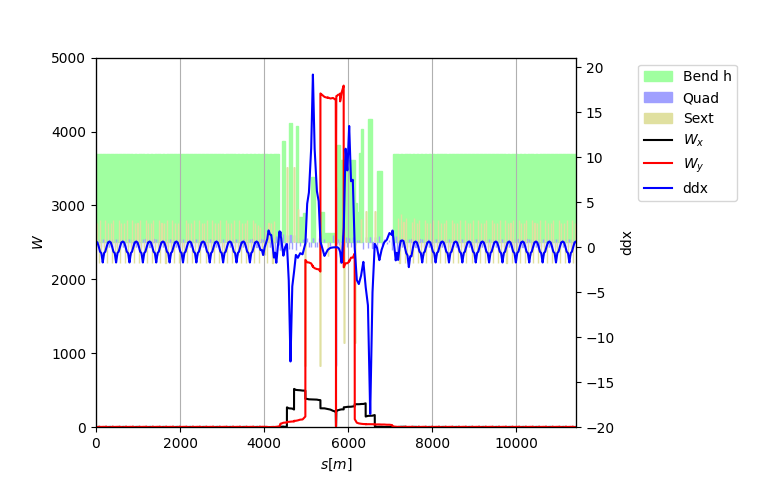

In [21]:
# W functions and second order dispersion before match
pp = opt.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=5000, right_lo=-20)

In [22]:
nlchr_2 = act.run()

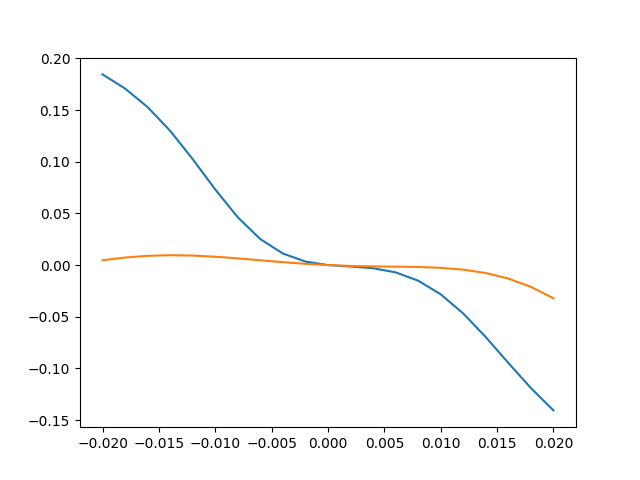

In [23]:
plt.figure()
plt.plot(nlchr_0['delta_test'], nlchr_0['mux_r_test'])
plt.plot(nlchr_2['delta_test'], nlchr_2['mux_r_test'])